# Тестовые SQL Мастерская
автор: Дедков Александр

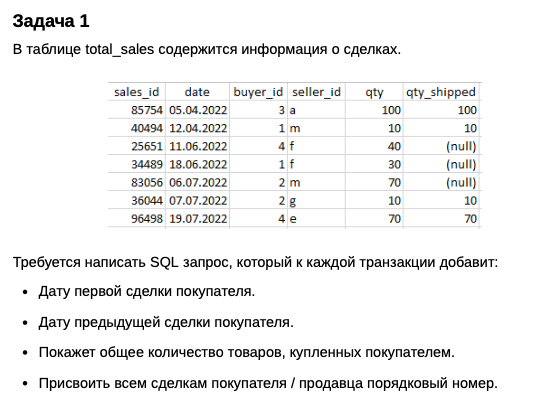

In [1]:
# импорты
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import random
from datetime import timedelta
from datetime import datetime
import string
import decimal

In [2]:
def random_date(first_date, second_date):
    first_timestamp = int(first_date.timestamp())
    second_timestamp = int(second_date.timestamp())
    random_timestamp = random.randint(first_timestamp, second_timestamp)
    return datetime.fromtimestamp(random_timestamp)

In [144]:
d1 = datetime.strptime('1/1/2023', '%m/%d/%Y')
d2 = datetime.strptime('12/20/2023', '%m/%d/%Y')
m = [random.randint(10, 100) for i in range(1000)]

data = dict()
data['sales_id'] = pd.Series([random.randint(10000, 99999) for i in range(1000)])
data['date'] = pd.Series([random_date(d1, d2).strftime("%d.%m.%Y") for i in range(1000)])
data['buyer_id'] = pd.Series([random.randint(0, 9) for i in range(1000)])
data['seller_id'] = pd.Series([random.choice(string.ascii_letters).lower() for i in range(1000)])
data['gty'] = pd.Series([i  for i in m])
data['gty_shipped'] = pd.Series(['(null)' if i % 7 == 0 else i  for i in m])

df_1 = pd.DataFrame(data)
df_1



,sales_id,date,buyer_id,seller_id,gty,gty_shipped
0,10233,02.03.2023,3,l,35,(null)
1,50462,15.08.2023,0,o,25,25
2,17366,25.04.2023,4,g,10,10
3,51996,12.05.2023,6,j,91,(null)
4,76441,01.06.2023,7,b,54,54
...,...,...,...,...,...,...
995,43622,02.05.2023,0,v,50,50
996,32460,14.06.2023,9,x,85,85
997,78493,15.01.2023,4,t,64,64
998,13605,23.04.2023,7,o,32,32


In [145]:
engine = create_engine("sqlite:///products-sqlalchemy.db")
df_1.to_sql('total_sales', engine,index=False,if_exists='replace')

In [146]:
query = '''
SELECT *
FROM total_sales
LIMIT 5;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,sales_id,date,buyer_id,seller_id,gty,gty_shipped
0,10233,02.03.2023,3,l,35,(null)
1,50462,15.08.2023,0,o,25,25
2,17366,25.04.2023,4,g,10,10
3,51996,12.05.2023,6,j,91,(null)
4,76441,01.06.2023,7,b,54,54


In [147]:
query = '''
select *,
  min(date) over (partition by buyer_id) as min_date,
  lag(date, 1) over (partition by buyer_id order by date) as pred_date,
  sum(gty) over (partition by buyer_id) as sum_gty,
  row_number() over (partition by buyer_id, seller_id order by date) as numb_seller
from total_sales;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,sales_id,date,buyer_id,seller_id,gty,gty_shipped,min_date,pred_date,sum_gty,numb_seller
0,12446,01.01.2023,0,e,35,(null),01.01.2023,None,6155,1
1,90745,01.02.2023,0,o,58,58,01.01.2023,01.01.2023,6155,1
2,57800,01.07.2023,0,y,95,95,01.01.2023,01.02.2023,6155,1
3,54756,02.03.2023,0,s,48,48,01.01.2023,01.07.2023,6155,1
4,85433,02.03.2023,0,u,22,22,01.01.2023,02.03.2023,6155,1
...,...,...,...,...,...,...,...,...,...,...
995,29113,28.09.2023,9,d,46,46,01.04.2023,28.07.2023,5688,5
996,35011,30.03.2023,9,y,78,78,01.04.2023,28.09.2023,5688,6
997,17024,30.06.2023,9,b,65,65,01.04.2023,30.03.2023,5688,3
998,57060,31.01.2023,9,n,91,(null),01.04.2023,30.06.2023,5688,3


# **Задача 2**
Схема базы данных

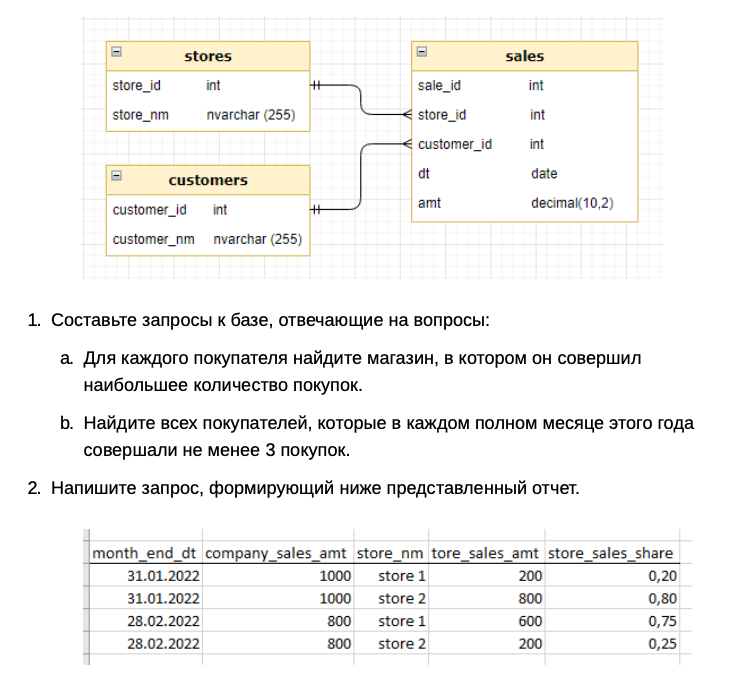

In [148]:
id_store = [random.randint(1, 10) for i in range(10)]
nm_store = ['store ' + str(i) for i in id_store]
id_customer = [random.randint(1, 1000) for i in range(1000)]
nm_customer = ['customer ' + str(i) for i in id_customer]
id_sale = [random.randint(1, 1000) for i in range(1000)]

stores = dict()
customers = dict()
sales = dict()

m_st = []
nm_st = []
for i in range(1000):
    id = random.randint(0, 9)
    m_st.append(id_store[id])
    nm_st.append(nm_store[id])
stores['store_id'] = m_st
stores['store_nm'] = nm_st

customers['customer_id'] = [i for i in id_customer]
customers['customer_nm'] = [i for i in nm_customer]

sales['sale_id'] = [i for i in id_sale]
sales['store_id'] = [id_store[random.randint(0, 9)] for i in range(1000)]
sales['customer_id'] = [i for i in id_customer]
sales['dt'] = pd.Series([random_date(d1, d2).strftime("%Y-%m-%d") for i in range(1000)])
decimal.getcontext().rounding = decimal.ROUND_CEILING
sales['amt'] = [float(round(decimal.Decimal(str(random.uniform(1, 1000000000))), ndigits=2)) for i in range(1000)]
df_stores = pd.DataFrame(stores)
df_customers = pd.DataFrame(customers)
df_sales = pd.DataFrame(sales)


In [149]:
df_stores.to_sql('stores', engine,index=False,if_exists='replace')
df_customers.to_sql('customers', engine,index=False,if_exists='replace')
df_sales.to_sql('sales', engine,index=False,if_exists='replace')

In [150]:
query = '''
SELECT *
FROM stores
LIMIT 5;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,store_id,store_nm
0,6,store 6
1,1,store 1
2,3,store 3
3,7,store 7
4,8,store 8


In [151]:
query = '''
SELECT *
FROM customers
LIMIT 5;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,customer_id,customer_nm
0,964,customer 964
1,647,customer 647
2,438,customer 438
3,271,customer 271
4,934,customer 934


In [152]:
query = '''
SELECT *
FROM sales
LIMIT 5;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,sale_id,store_id,customer_id,dt,amt
0,598,5,964,2023-06-20,9.126991e+08
1,82,9,647,2023-07-19,4.105758e+07
2,869,5,438,2023-01-24,6.011312e+08
3,639,8,271,2023-03-25,5.304769e+08
4,846,7,934,2023-09-25,1.815030e+08


**1_a**

In [153]:
query = '''
    select
        ct_id,
        top as top_store_id
        from (
                select
                    distinct customer_id as ct_id,
                    store_id as top,
                    count(store_id) as cnt
                from sales
                group by ct_id, store_id
        ) as ct
        group by ct_id
        having max(cnt) = cnt
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,ct_id,top_store_id
0,1,7
1,2,9
2,3,8
3,4,6
4,6,1
...,...,...
614,992,1
615,993,1
616,994,9
617,997,7


In [154]:
query = '''
with cust_top as (
    select
        ct_id,
        top as top_store_id
        from (
                select
                    distinct customer_id as ct_id,
                    store_id as top,
                    count(store_id) as cnt
                from sales
                group by ct_id, store_id
        ) as ct
        group by ct_id
        having max(cnt) = cnt
)
select
    distinct c.ct_id,
    customer_nm,
    c.top_store_id,
    store_nm as top_st_nm
from cust_top c
inner join stores on c.top_store_id = stores.store_id
inner join customers on c.ct_id = customers.customer_id
order by c.ct_id;
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,ct_id,customer_nm,top_store_id,top_st_nm
0,1,customer 1,7,store 7
1,2,customer 2,9,store 9
2,3,customer 3,8,store 8
3,4,customer 4,6,store 6
4,6,customer 6,1,store 1
...,...,...,...,...
614,992,customer 992,1,store 1
615,993,customer 993,1,store 1
616,994,customer 994,9,store 9
617,997,customer 997,7,store 7


**1_b**

In [160]:
query = '''
select
        customer_id,
        dt,
        strftime('%m', dt),
        date('now'),
        strftime('%Y', date('now')),
        count(sale_id)
    from sales
    where strftime('%Y', dt) = strftime('%Y', date('now')) and strftime('%m', dt) != strftime('%m', date('now'))
    group by customer_id, strftime('%m', dt)
    having count(sale_id) >= 3
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,customer_id,dt,"strftime('%m', dt)",date('now'),"strftime('%Y', date('now'))",count(sale_id)
0,898,2023-04-27,04,2023-07-18,2023,3


In [159]:
query = '''
with cus_list as (
    select
        customer_id,
        dt,
        strftime('%m', dt),
        date('now'),
        strftime('%Y', date('now')),
        count(sale_id)
    from sales
    where strftime('%Y', dt) = strftime('%Y', date('now')) and strftime('%m', dt) != strftime('%m', date('now'))
    group by customer_id, strftime('%m', dt)
    having count(sale_id) >= 3
)
select
    customer_nm
from customers
where customer_id in (
    select
        customer_id
    from cus_list
    group by customer_id
    having count(*) = ((select count(distinct strftime('%Y', dt)) from sales) - 1)
    )
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,customer_nm


**2. Напишите запрос, формирующий ниже представленный отчет.**

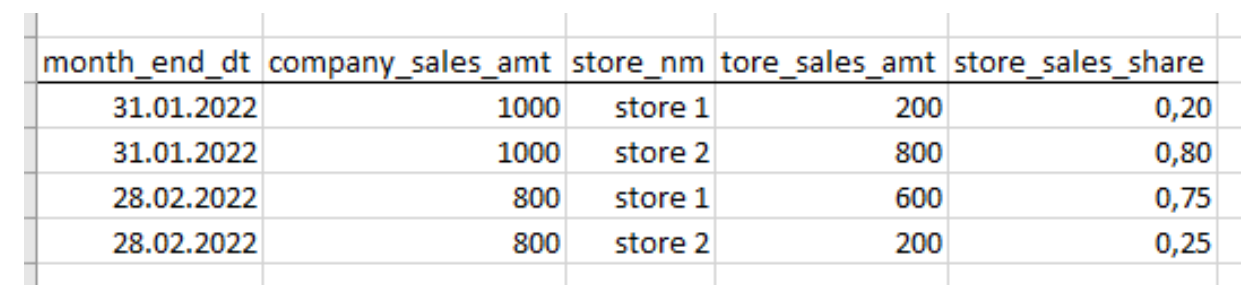

In [163]:
query = '''
with store_sales as (
    select
        strftime('%m', dt) + (date(dt, '+1 month') - date(dt, '-1 day')) as month_end_dt,
        sum(amt) as store_sales_amt,
        store_nm
    from sales
    left join stores on stores.store_id = sales.store_id
    group by month_end_dt, store_nm
    order by month_end_dt, store_nm
),
company_sales as (
    select
        *,
        sum(store_sales_amt) over (partition by month_end_dt) as company_sales_amt
    from store_sales
)
select
    month_end_dt,
    company_sales_amt,
    store_nm,
    store_sales_amt,
    round(store_sales_amt / company_sales_amt, 2) as store_sales_share
from company_sales


'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,month_end_dt,company_sales_amt,store_nm,store_sales_amt,store_sales_share
0,1,5.696475e+12,store 1,1.401871e+12,0.25
1,1,5.696475e+12,store 3,3.819592e+11,0.07
2,1,5.696475e+12,store 5,2.982627e+11,0.05
3,1,5.696475e+12,store 6,3.334768e+11,0.06
4,1,5.696475e+12,store 7,1.282787e+12,0.23
...,...,...,...,...,...
79,13,4.616127e+12,store 5,5.969803e+11,0.13
80,13,4.616127e+12,store 6,4.807963e+11,0.10
81,13,4.616127e+12,store 7,8.030555e+11,0.17
82,13,4.616127e+12,store 8,8.313044e+10,0.02


# **Задача 3**
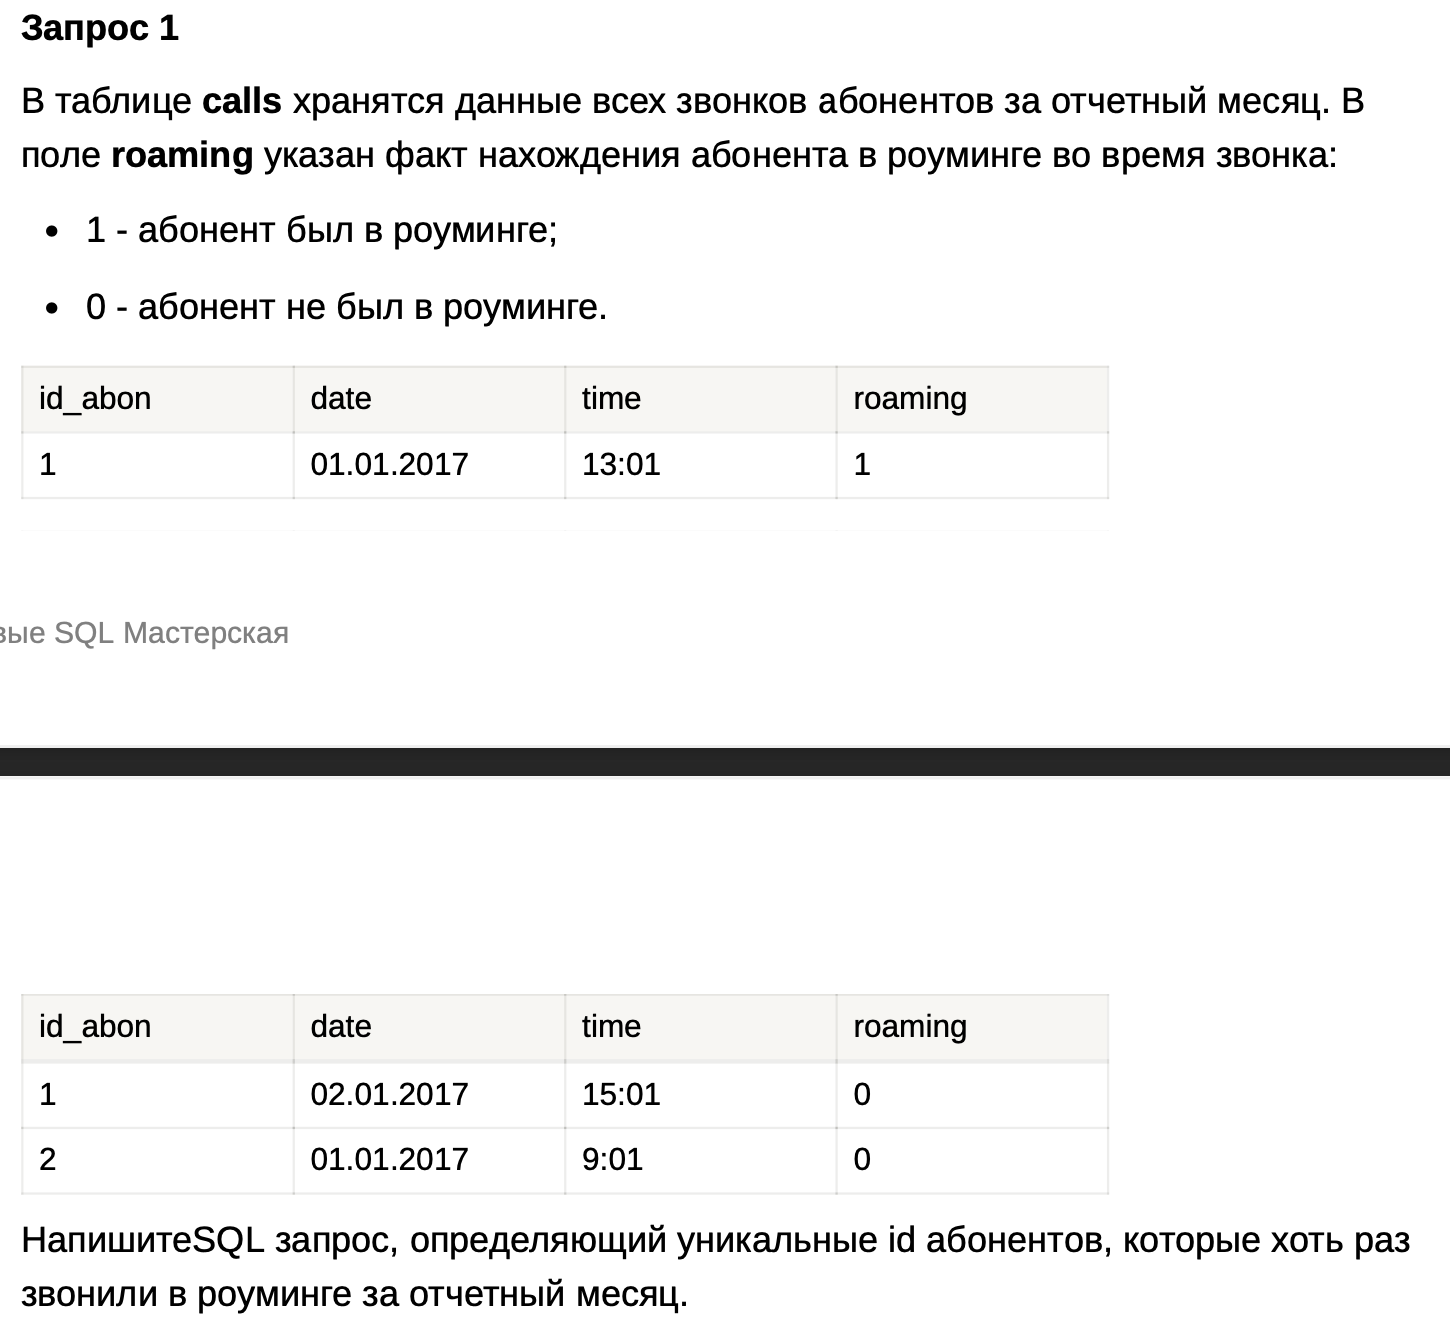

In [ ]:
d1 = datetime.strptime('1/1/2017', '%m/%d/%Y')
d2 = datetime.strptime('1/31/2017', '%m/%d/%Y')
m = [random.randint(0, 1) for i in range(1000)]

data = dict()
data['id_abon'] = pd.Series([random.randint(1, 100) for i in range(1000)])
data['date'] = pd.Series([random_date(d1, d2).strftime("%d.%m.%Y") for i in range(1000)])
data['time'] = pd.Series([random_date(d1, d2).strftime("%H:%M") for i in range(1000)])
data['roaming'] = pd.Series([i  for i in m])


calls = pd.DataFrame(data)
calls.head()

,id_abon,date,time,roaming
0,34,29.01.2017,18:00,0
1,100,25.01.2017,15:14,1
2,48,03.01.2017,00:26,1
3,53,29.01.2017,01:12,1
4,14,28.01.2017,08:53,0


In [ ]:
calls.to_sql('calls', engine,index=False,if_exists='replace')

1000

In [ ]:
query = '''
select
  distinct id_abon
from calls
where roaming = '1'
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,id_abon
0,100
1,48
2,53
3,70
4,92
...,...
95,45
96,50
97,78
98,77


## Запрос 2

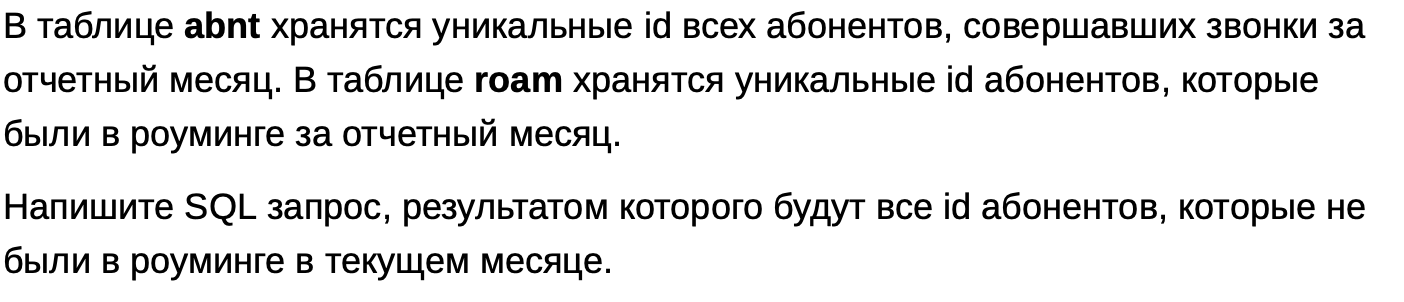

In [ ]:
data = dict()
data['id_abon'] = pd.Series([random.randint(1, 100) for i in range(1000)])
data['clc'] = pd.Series([random.randint(1, 1000) for i in range(1000)])

abnt = pd.DataFrame(data)
abnt.head()

,id_abon,clc
0,71,407
1,61,753
2,96,207
3,80,857
4,61,268


In [ ]:
abnt.to_sql('abnt', engine,index=False,if_exists='replace')

1000

In [ ]:
data = dict()
data['id_abon'] = pd.Series([random.randint(1, 100) for i in range(50)])
data['clc'] = pd.Series([random.randint(1, 1000) for i in range(50)])

roam = pd.DataFrame(data)
roam.head()

,id_abon,clc
0,44,766
1,51,303
2,6,585
3,7,303
4,21,788


In [ ]:
roam.to_sql('roam', engine,index=False,if_exists='replace')

50

In [ ]:
query = '''
SELECT id_abon
FROM abnt
WHERE abnt.id_abon NOT IN (SELECT id_abon FROM roam)

'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,id_abon
0,71
1,96
2,80
3,71
4,100
...,...
550,57
551,9
552,90
553,100


## Запрос 3

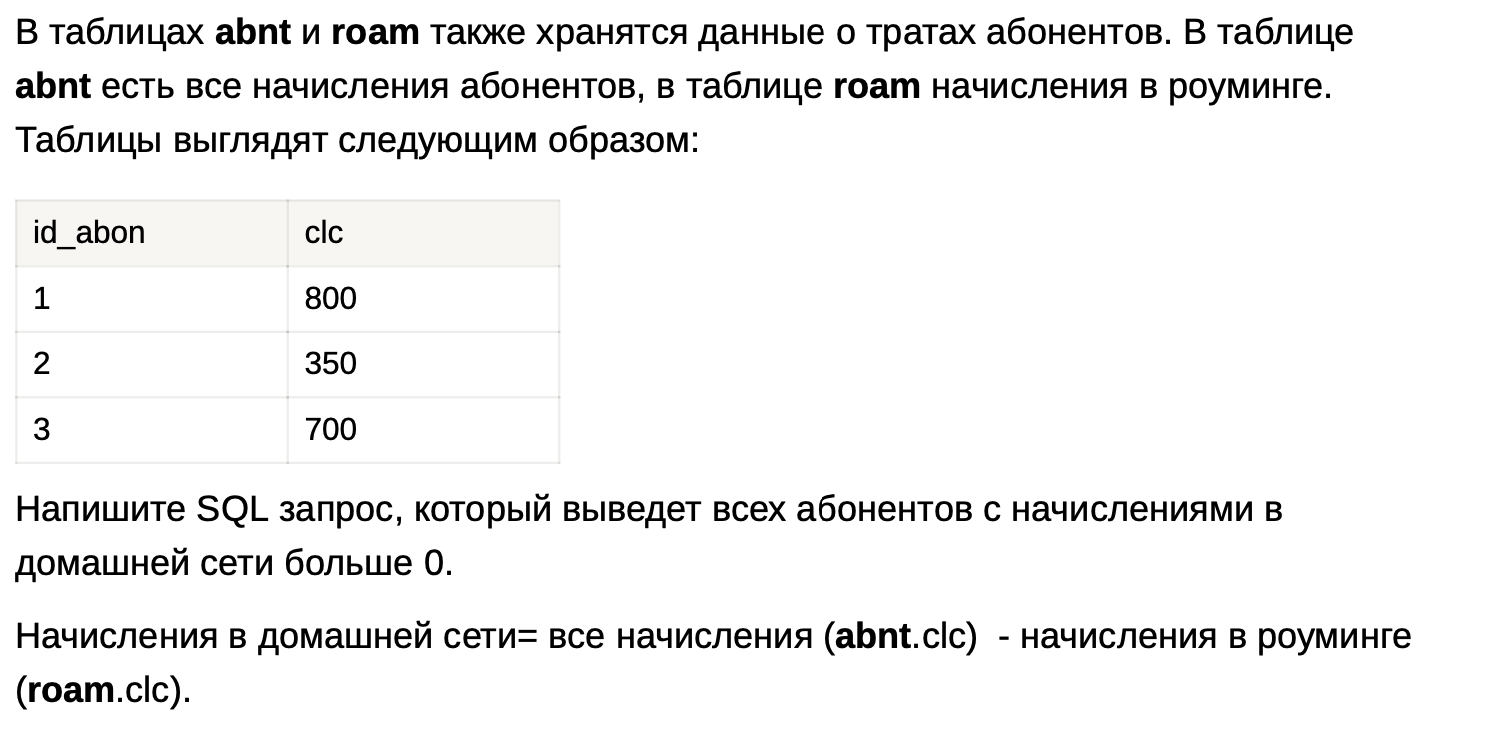

In [ ]:
query = '''
with rr as (
SELECT id_abon
FROM abnt
WHERE abnt.id_abon NOT IN (SELECT id_abon FROM roam)
)
select
s.id_abon
from abnt s
inner join rr r on r.id_abon = s.id_abon
where s.clc > 0
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,id_abon
0,71
1,71
2,71
3,71
4,71
...,...
5992,9
5993,9
5994,9
5995,9


## Запрос 4

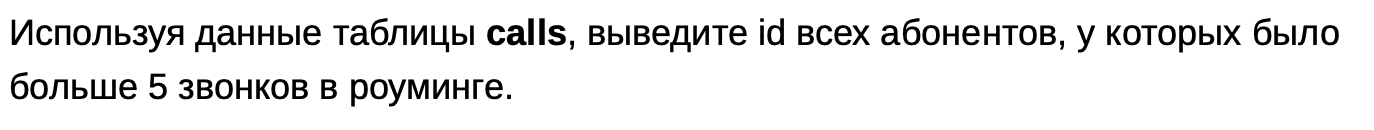

In [ ]:
query = '''
select
  id_abon,
  sum(roaming) as sum_roaming
from calls
group by id_abon
having sum_roaming > 5
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,id_abon,sum_roaming
0,2,9
1,5,6
2,6,6
3,7,8
4,8,7
5,20,6
6,22,7
7,23,8
8,24,9
9,28,9


## Задача 4
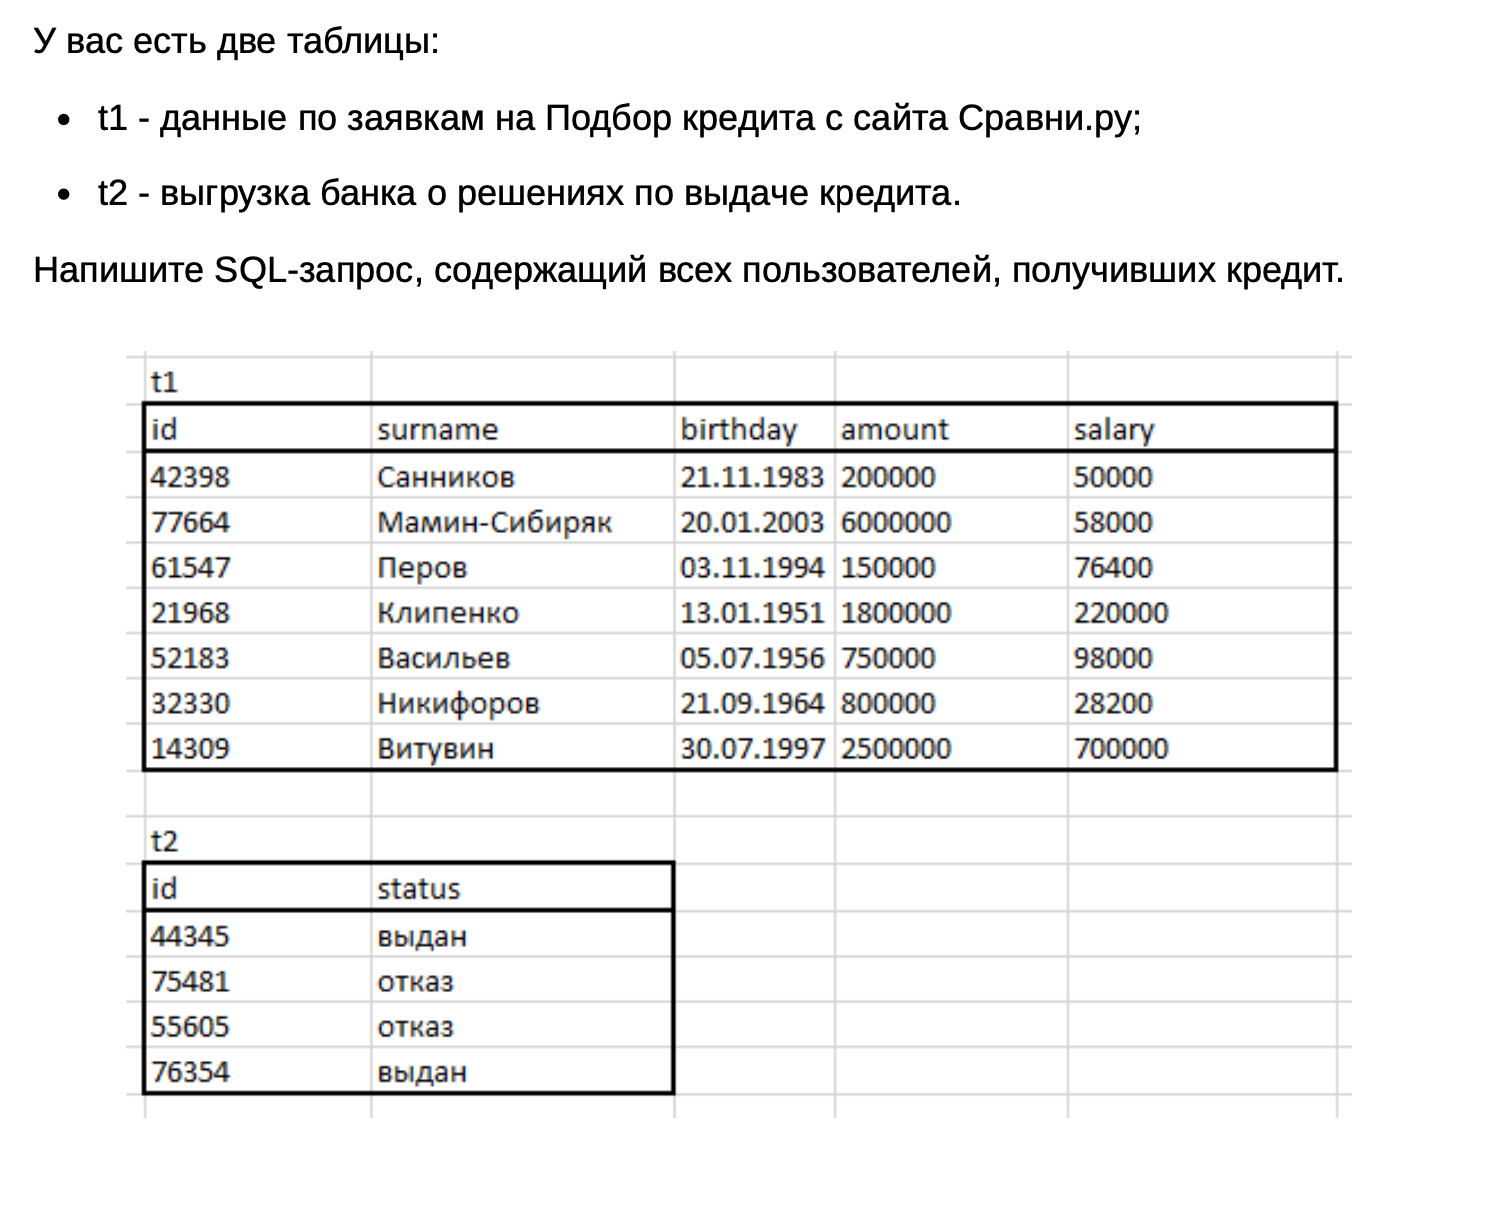

In [ ]:
!pip install names

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 KB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803698 sha256=0c5101e227437699b3e883543f07969c42474e794eb4f7fadaa613c71241808c
  Stored in directory: /root/.cache/pip/wheels/f1/bc/04/55ab9499ea02359ece8b02b4169ebb30aa52d82b84c13fc506
Successfully built names


In [ ]:
import names

In [ ]:
names.get_full_name().split()[1]

'Langlois'

In [ ]:
d1 = datetime.strptime('1/1/1950', '%m/%d/%Y')
d2 = datetime.strptime('1/31/1997', '%m/%d/%Y')
m = [random.randint(0, 1) for i in range(1000)]

data = dict()
data['id'] = pd.Series([random.randint(10000, 99999) for i in range(1000)])
data['surname'] = [names.get_full_name().split()[1] for i in range(1000)]
data['birthday'] = pd.Series([random_date(d1, d2).strftime("%d.%m.%Y") for i in range(1000)])
data['amount'] = pd.Series([random.randint(1, 100) for i in range(1000)])
data['salary'] = pd.Series([random.randint(1, 100) for i in range(1000)])

t1 = pd.DataFrame(data)

In [ ]:
st = ['выдан', 'отказ']
data = dict()
data['id'] = pd.Series([random.randint(10000, 99999) for i in range(1000)])
data['status'] = pd.Series([st[random.randint(0, 1)] for i in range(1000)])
t2 = pd.DataFrame(data)

In [ ]:
t1.to_sql('t1', engine,index=False,if_exists='replace')
t2.to_sql('t2', engine,index=False,if_exists='replace')

1000

In [ ]:
query = '''
select
*
from t1
where id in (
select id from t2 where status = 'выдан'
)
'''
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,id,surname,birthday,amount,salary
0,58918,Montano,11.08.1958,37,55
1,36797,Martin,09.03.1980,45,99
2,34460,Deleo,14.08.1991,81,41
3,42872,Vandy,20.05.1981,81,5
4,88654,Stills,29.09.1950,20,37
5,55796,Ayala,26.12.1967,10,86
6,61486,Lawson,22.01.1988,65,71
